***A Large-Scale Dataset for Segmentation and Classification***

Authors: O. Ulucan, D. Karakaya, M. Turkan
Department of Electrical and Electronics Engineering, Izmir University of Economics, Izmir, Turkey
Corresponding author: M. Turkan
Contact Information: mehmet.turkan@ieu.edu.tr


***General Introduction***

This dataset contains 9 different seafood types collected from a supermarket in Izmir, Turkey
for a university-industry collaboration project at Izmir University of Economics, and this work
was published in ASYU 2020.
Dataset includes, gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, 
black sea sprat, striped red mullet, trout, shrimp image samples. 

If you use this dataset in your work, please consider to cite:

@inproceedings{ulucan2020large,
  title={A Large-Scale Dataset for Fish Segmentation and Classification},
  author={Ulucan, Oguzhan and Karakaya, Diclehan and Turkan, Mehmet},
  booktitle={2020 Innovations in Intelligent Systems and Applications Conference (ASYU)},
  pages={1--5},
  year={2020},
  organization={IEEE}
}

* O.Ulucan , D.Karakaya and M.Turkan.(2020) A large-scale dataset for fish segmentation and classification.
In Conf. Innovations Intell. Syst. Appli. (ASYU)

***Purpose of the work***

This dataset was collected in order to carry out segmentation, feature extraction and classification tasks
and compare the common segmentation, feature extraction and classification algortihms (Semantic Segmentation, Convolutional Neural Networks, Bag of Features).
All of the experiment results prove the usability of our dataset for purposes mentioned above.


***Data Gathering Equipment and Data Augmentation***

Images were collected via 2 different cameras, Kodak Easyshare Z650 and Samsung ST60. 
Therefore, the resolution of the images are 2832 x 2128, 1024 x 768, respectively.

Before the segmentation, feature extraction and classification process, the dataset was resized to 590 x 445
by preserving the aspect ratio. After resizing the images, all labels in the dataset were augmented (by flipping and rotating). 

At the end of the augmentation process, the number of total images for each class became 2000; 1000 for the RGB fish images
and 1000 for their pair-wise ground truth labels. 


***Description of the data in this data set***

The dataset contains 9 different seafood types. For each class, there are 1000 augmented images and their pair-waise augmented ground truths.
Each class can be found in the "Fish_Dataset" file with their ground truth labels. All images for each class are ordered from "00000.png" to "01000.png".
 
For example, if you want to access the ground truth images of the shrimp in the dataset, the order should be followed is "Fish->Shrimp->Shrimp GT". 

In [1]:
import os
import shutil
import glob
import logging
from tqdm import tqdm
from typing import Optional, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2 as cv
from tensorflow.keras.preprocessing.image import load_img, img_to_array

pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))

## 1. Explatory Data Analysis

In [2]:
fish_dataset_directory ="/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"

In [3]:
def find_image_classes(images_path: str) -> List[str]:
    """
    Find subdirectory names in the specified directory.

    Parameters
    ----------
    images_path : str
        Path to the directory containing subdirectories.

    Returns
    -------
    List[str]
        A list of subdirectory names found within the specified directory.

    Example
    -------
    classes = find_image_classes("path/to/fish_dataset_directory")
    print(classes)
    """
    return [i for i in os.listdir(images_path) if os.path.isdir(os.path.join(images_path, i))]


In [4]:
image_classes = find_image_classes(fish_dataset_directory)
image_classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [5]:
def df_from_image_folders(images_path: str, extension: Optional[str] = "png") -> pd.DataFrame:
    """
    Create a DataFrame from image files in specified directories.

    Parameters
    ----------
    images_path : str
        Path to the directory containing subdirectories of images.
    extension : str, optional
        The file extension of the images to include (default is "png").

    Returns
    -------
    pd.DataFrame
        A DataFrame with two columns: 'path' containing file paths and 'label' containing the class labels.

    Notes
    -----
    Excludes directories that contain 'GT' in their names.

    Example
    -------
    df = df_from_image_folders("path/to/fish_dataset_directory")
    print(df.head())
    """
    
    label = []
    path = []
    image_files = glob.glob(os.path.join(images_path, "**", f"*.{extension.lower()}"), recursive=True)

    for file in image_files:
        dirpath = os.path.dirname(file)
        folder_name = os.path.basename(dirpath)
        if "GT" not in folder_name:
            label.append(folder_name)
            path.append(file)

    class_dict = {"path": path, "label": label}
    return pd.DataFrame(class_dict)


In [6]:
df = df_from_image_folders(fish_dataset_directory)
df.head()

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00704.png,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00562.png,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00237.png,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00406.png,Hourse Mackerel


In [7]:
def display_fish_from_each_class(df: pd.DataFrame, img_size: Tuple[int, int] = (224, 224)) -> None:
    """
    Displays one image from each unique class in the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing image paths and labels.
    img_size : Tuple[int, int]
        Size to which images will be resized for display.
    """
    
    plt.figure(figsize=(12, 12))
    
    for i, unique_label in enumerate(df["label"].unique()):
        
        plt.subplot(3, 3, i + 1)
        image_path = df[df["label"] == unique_label].iloc[0, 0]
        img = load_img(image_path, target_size=img_size)
        plt.imshow(img)
        plt.title(unique_label)
        plt.axis('off')

    plt.show()

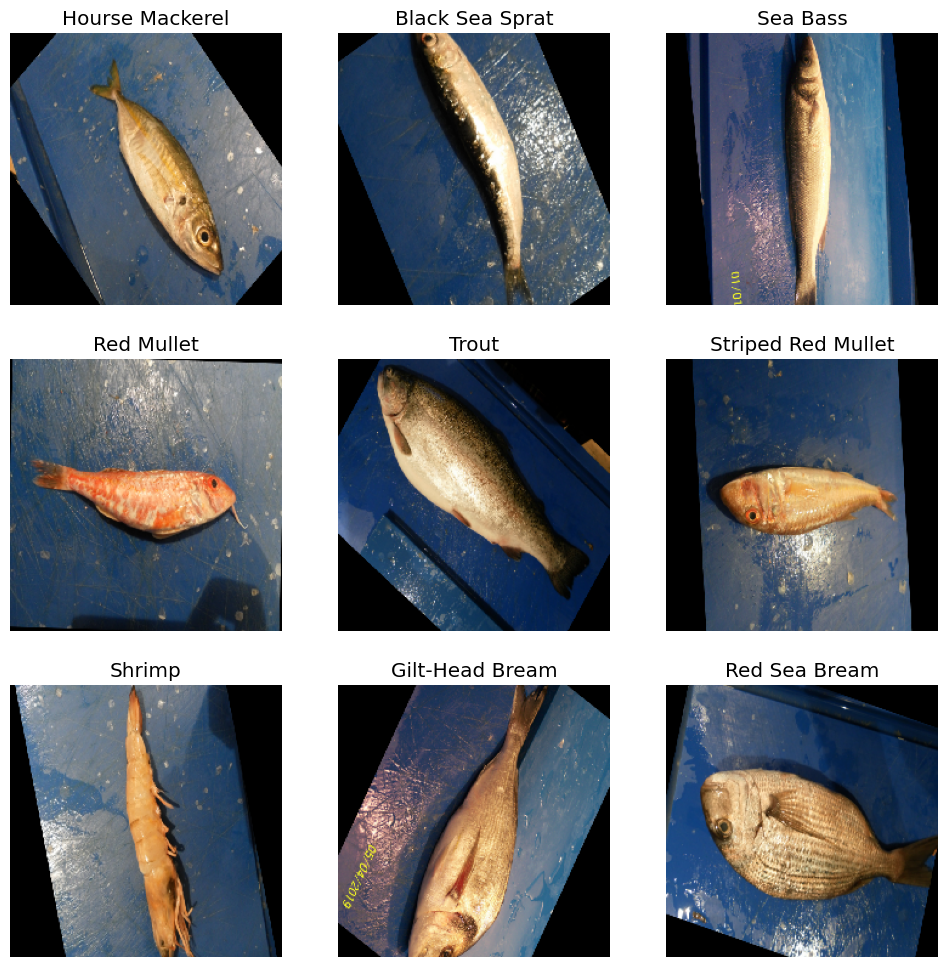

In [8]:
display_fish_from_each_class(df)

In [9]:
def display_images_from_class(df: pd.DataFrame, class_name: str, num_images: int, img_size: Tuple[int, int] = (224, 224)) -> None:
    """
    Displays a specified number of images from a given class in the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing image paths and labels.
    class_name : str
        The class label to filter the images.
    img_size : Tuple[int, int]
        Size to which images will be resized for display.
    num_images : int
        Number of images to display from the given class.
    """
    images = df[df["label"] == class_name]["path"].iloc[:num_images]
    plt.figure(figsize=(12, 12))

    for i, image_path in enumerate(images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(load_img(image_path, target_size=img_size))
        plt.title(image_path[-5:-4]) 
        plt.axis('off')

    plt.show()


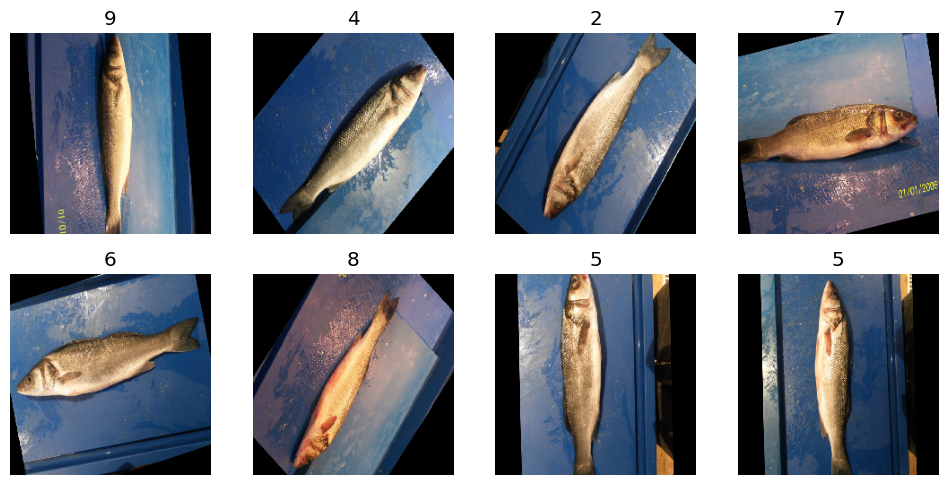

In [10]:
display_images_from_class(df, "Sea Bass", 8)

### 1.2 Görüntülerin boyutunu, renk kanallarını ve dağılımlarını analiz edilmesi

In [11]:
df["label"].nunique()

9

In [12]:
df[["label"]].value_counts()

label             
Black Sea Sprat       1000
Gilt-Head Bream       1000
Hourse Mackerel       1000
Red Mullet            1000
Red Sea Bream         1000
Sea Bass              1000
Shrimp                1000
Striped Red Mullet    1000
Trout                 1000
Name: count, dtype: int64

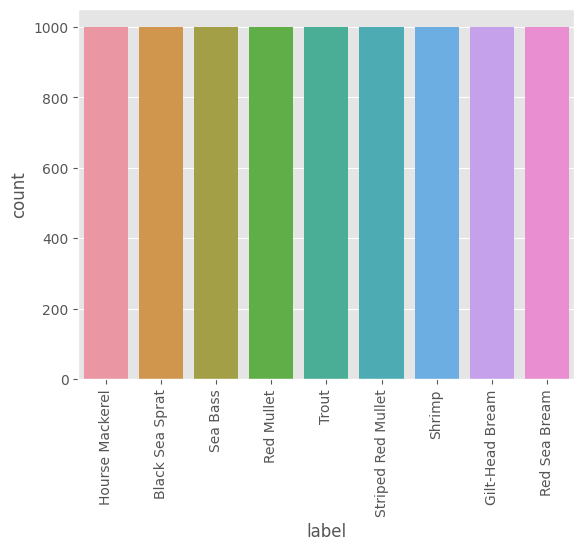

In [13]:
sns.countplot(x="label", data = df )
plt.xticks(rotation = 90)
plt.show()

**Boyut ve renk kanalları analizi yapılarak ortalama genişlik ve yükseklik değerleri belirlenip, yeniden boyutlandırma için uygun genişlik ve yükseklik değerleri seçilmiştir.**

In [14]:

def compute_image_statistics_from_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes average width, height, and channel count for images listed in the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'path' and 'label' columns for images.

    Returns:
        pd.DataFrame: DataFrame containing average statistics for each fish class.
    """
    stats = []

    grouped = df.groupby('label')

    for label, group in grouped:
        widths = []
        heights = []
        channel_counts = []

        for _, row in group.iterrows():
            image_path = row['path']
            try:
                image = load_img(image_path)
                image_array = img_to_array(image)
                
                width, height = image.size
                widths.append(width)
                heights.append(height)
                channel_counts.append(image_array.shape[2])
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
        
        if widths:  
            avg_width = np.mean(widths)
            avg_height = np.mean(heights)
            avg_channels = np.mean(channel_counts)
            min_width = np.min(widths)
            max_width = np.max(widths)
            min_height = np.min(height)
            max_height = np.max(height)

            stats.append({
                'Fish Class': label,
                'Average Width': avg_width,
                'Average Height': avg_height,
                'Average Channels': avg_channels,
                'Min Width': min_width,
                'Max Width' : max_width,
                'Min Height' : min_height,
                'Max Height' : max_height  
            })

    return pd.DataFrame(stats)


In [15]:
df_statistics = compute_image_statistics_from_df(df)
df_statistics

,Fish Class,Average Width,Average Height,Average Channels,Min Width,Max Width,Min Height,Max Height
0,Black Sea Sprat,590.0,445.0,3.0,590,590,445,445
1,Gilt-Head Bream,590.0,445.0,3.0,590,590,445,445
2,Hourse Mackerel,590.0,445.0,3.0,590,590,445,445
3,Red Mullet,590.0,445.0,3.0,590,590,445,445
4,Red Sea Bream,590.0,445.0,3.0,590,590,445,445
5,Sea Bass,590.0,445.0,3.0,590,590,445,445
6,Shrimp,590.0,445.0,3.0,590,590,445,445
7,Striped Red Mullet,590.0,445.0,3.0,590,590,445,445
8,Trout,590.0,445.0,3.0,590,590,445,445


In [16]:
def display_rgb_channels(image_path: str) -> None:
    """
    Displays the individual RGB channels of an image.

    Parameters
    ----------
    image_path : str
        The file path to the image.

    Returns
    -------
    None
    """
    image = Image.open(image_path)
    
    r, g, b = image.split()
    
    r_array = np.array(r)
    g_array = np.array(g)
    b_array = np.array(b)

    fig, axes = plt.subplots(1, 3, figsize=(12,12))

    axes[0].imshow(r_array, cmap="Reds")
    axes[0].set_title("Red Channel")
    axes[0].axis("off")

    axes[1].imshow(g_array, cmap="Greens")
    axes[1].set_title("Green Channel")
    axes[1].axis("off")

    axes[2].imshow(b_array, cmap="Blues")
    axes[2].set_title("Blue Channel")
    axes[2].axis("off")


    plt.show()


**Örnek bir resmin renk kanallarının görselleştirilmesi**

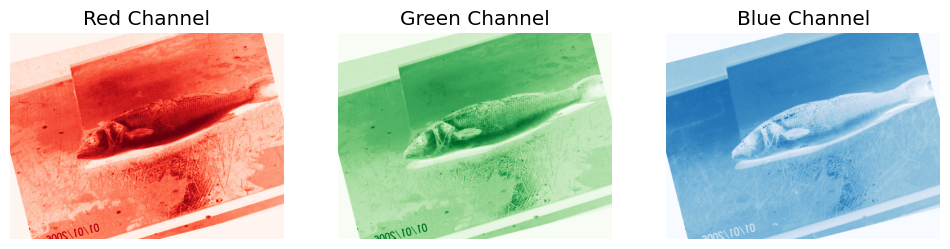

In [17]:
sample_image = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00026.png"
display_rgb_channels(sample_image)

### 1.3 Görüntüler üzerinde ön işleme adımlarını gerçekleştirilmesi.

- **Veri setinde çok sayıda resim olduğundan bu resimleri en iyi şekilde ayıklamak için ön işleme adımları gerçekleştirilmiştir.**

- **cropping, embedding, clustering, splitting, normalizasyon ve data augmentation işlemleri yapılmıştır.**

- **Görüntülerin hepsi aynı boyutta olduğundan min max resolution filtre uygulanmamıştır. Eğer bu görüntüler internetten scrape edilmiş farklı boyutlarda resimler olsaydı bütün resimlere aynı boyut verilip altında kalan resimler veri setinden çıkarılabilirdi**

**Image Cropping Demo**

**This section aims to show how smart cropping works. Smart cropping, removes the unneccessary parts of the image and focuses the main object of the image. For this purpose all images converted to PIL image** 


In [18]:
logging.basicConfig(
    level=logging.INFO, format= "%(asctime)s - %(levelname)s - %(message)s"
)


def load_image(image_path: str) -> Image.Image:
    """
    Load an image in RGB format from the given path.

    Parameters
    ----------
    image_path : str
        Path to the image file.

    Returns
    -------
    Image.Image
        Loaded image.
    """
    image = Image.open(image_path).convert("RGB")
    return image

def load_images_from_df(df: pd.DataFrame) -> List[Image.Image]:
    """
    Load images from a DataFrame containing image paths.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with a column "path" for image file paths.

    Returns
    -------
    List[Image.Image]
        List of loaded images.
    """
    images = [load_image(image_path) for image_path in tqdm(df["path"].values.tolist(), total=len(df))]
    logging.info(f"Loaded {len(images)} images from DataFrame")
    return images

In [19]:
loaded_images = load_images_from_df(df)

100%|██████████| 9000/9000 [01:58<00:00, 76.27it/s]


**Image Cropping**

In [20]:
def plot_image(image: Image.Image) -> None:
    """
    Display an image using matplotlib with the axis turned off.
    
    Parameters
    ----------
    image : Image.Image
        The image to be displayed.
    
    Returns
    -------
    None
    """
    plt.imshow(image)
    plt.axis("off")
    plt.show()

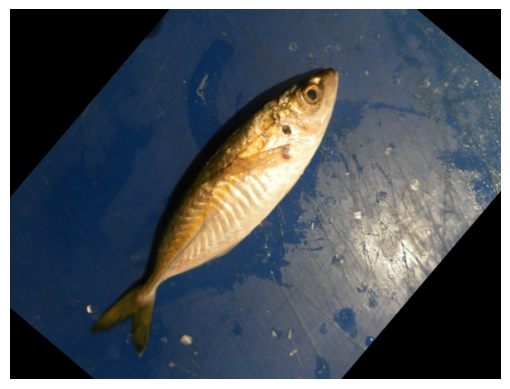

In [21]:
plot_image(loaded_images[20])

**Smart Crop Script**

In [22]:

EXTENSIONS = ("jpg", "JPG", "jpeg", "JPEG", "png", "PNG")

def detect(pil_image: Image.Image, square: bool = False) -> np.ndarray:
    """
    Detect keypoints in the image using SIFT and apply cropping.

    Parameters
    ----------
    pil_image : Image.Image
        The input image to detect keypoints and crop.
    square : bool, optional
        If True, the output image will be square-shaped. Defaults to False.
    
    Returns
    -------
    np.ndarray
        The cropped image as a numpy array.
    """
    img = np.array(pil_image)  # Convert PIL image to numpy array
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)  # Convert to grayscale
    sift = cv.SIFT_create(edgeThreshold=8)
    kp = sift.detect(gray, None)

    all_points = [i.pt for i in kp]
    x_points = [z[0] for z in all_points]
    y_points = [z[1] for z in all_points]
    thresh = 0
    x_min, y_min = int(min(x_points)) - thresh, int(min(y_points) - thresh)
    x_max, y_max = int(max(x_points)) + thresh, int(max(y_points) + thresh)
    min_side = min((x_max - x_min), (y_max - y_min))
    max_side = max((x_max - x_min), (y_max - y_min))
    x_mean, y_mean = int((x_max + x_min) / 2), int((y_max + y_min) / 2)

    squared_x_min, squared_x_max = x_mean - int(min_side / 2), x_mean + int(min_side / 2)
    squared_y_min, squared_y_max = y_mean - int(min_side / 2), y_mean + int(min_side / 2)

    if not square:
        return img[y_min:y_max, x_min:x_max]  # Non-square crop

    return img[squared_y_min:squared_y_max, squared_x_min:squared_x_max] 

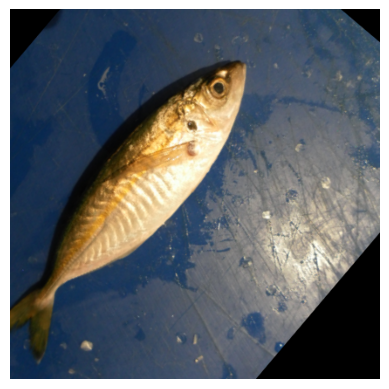

In [23]:
cropped_image = detect(loaded_images[20], square=True)
plot_image(cropped_image)

**Image Preprocessing and Saving to Disk**

Helper Functions

In [24]:
def process_image(image: Image.Image, square: bool = True) -> Image.Image:
    """
    Apply smart cropping to the image using SIFT keypoints detection.

    Parameters
    ----------
    image : Image.Image
        The image to be processed and cropped.
    square : bool, optional
        If True, the output image will be square-shaped. Defaults to True.
    
    Returns
    -------
    Image.Image
        Cropped image based on detected keypoints.
    """
    cropped_image = detect(image, square=square)
    return Image.fromarray(cropped_image)

def create_directory(dir_path: str) -> None:
    """
    Create a directory if it doesn't exist.
    
    Parameters
    ----------
    dir_path : str
        The path of the directory to create.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        logging.info(f"Directory created: {dir_path}")
    else:
        logging.info(f"Directory already exists: {dir_path}")
        

def save_image(image: Image.Image, save_path: str) -> None:
    """
    Save a PIL image to a specific path.
    
    Parameters
    ----------
    image : Image.Image
        The image to save.
    save_path : str
        The path where the image should be saved.
    """
    image.save(save_path)
    logging.info(f"Saved image to {save_path}")


def process_and_save_images(df: pd.DataFrame, output_base_dir: str) -> None:
    """
    Load, process, and save images organized by labels into respective directories.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing 'path' and 'label' columns for images and their labels.
    output_base_dir : str
        The base directory where images will be saved, organized by labels.
    """
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        image_path = row['path']
        label = row['label']
        
        image = load_image(image_path)
        
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image) 
        if not isinstance(image, Image.Image):
            raise ValueError("Input image must be a numpy array or PIL image")
        if image.mode != "RGB":
            image = image.convert("RGB") 
        
        processed_image = process_image(image, square=True)
        
        label_dir = os.path.join(output_base_dir, label)
        create_directory(label_dir)
        
        image_name = os.path.basename(image_path) 
        save_path = os.path.join(label_dir, image_name) 
        
        save_image(processed_image, save_path)

In [25]:
output_path = "/kaggle/working/preprocessed_images"

In [26]:
process_and_save_images(df, output_path )

100%|██████████| 9000/9000 [34:10<00:00,  4.39it/s]


In [27]:
# if os.path.exists(output_path):
#     shutil.rmtree(output_path)  # Klasörü ve içindeki her şeyi sil
#     print(f"{output_path} has been deleted.")
# else:
#     print(f"{output_path} does not exist.")

In [28]:





# # Resimleri boyutlandırma ve filtreleme işlemleri
# max_size = 350
# resized_images = [max_resolution_rescale(img, max_size, max_size) for img in tqdm(loaded_images)]

# min_size = 224
# min_filtered_images = [img for img in tqdm(resized_images) if min_resolution_filter(img, min_size, min_size)]

# # Sonuçları kaydetme ve diğer işlemler
# cropped_images = [detect(img, square=True) for img in tqdm(min_filtered_images)]
# save_images_to_dir(cropped_images, "data/preprocessed_train/fish")
